
<img src="Units1_2/assets/telemarketing.jpeg", alt="Photo of Midwestern Home", height="200", width="300">


# UCI Machine Learning 
## Bank Telemarketing Dataset

Goal: To develop a model which can predict positive outcomes in a bank telemarketing campaign, in order to more effectively market to the right groups of people. 

To stratify customers into tiers - to focus marketing where the ROI is positive. 

The dataset: This dataset was developed by a Portuguese bank during a telemarketing campaign 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from scipy import stats
from imblearn import under_sampling

%matplotlib inline

In [2]:
data = pd.read_csv("/Users/jacquelynzuker/Desktop/bank-additional/bank-additional-full.csv", sep=';')
print("Dimensions of Consumer Bank Data: ", data.shape)

data = data.sample(frac=1).reset_index(drop=True)
smalls = pd.read_csv("/Users/jacquelynzuker/Desktop/bank-additional/bank-additional.csv", sep=';')
#print("Dimensions of Smaller training Data set", smalls.shape)

#data = smalls

Dimensions of Consumer Bank Data:  (41188, 21)


In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,35,technician,married,professional.course,no,no,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
1,37,admin.,divorced,high.school,no,yes,yes,telephone,nov,mon,...,5,999,0,nonexistent,-3.4,92.649,-30.1,0.722,5017.5,no
2,41,technician,married,professional.course,no,no,no,cellular,apr,fri,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
3,29,admin.,married,professional.course,no,no,no,telephone,jun,wed,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,38,blue-collar,married,basic.9y,no,yes,no,telephone,may,fri,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


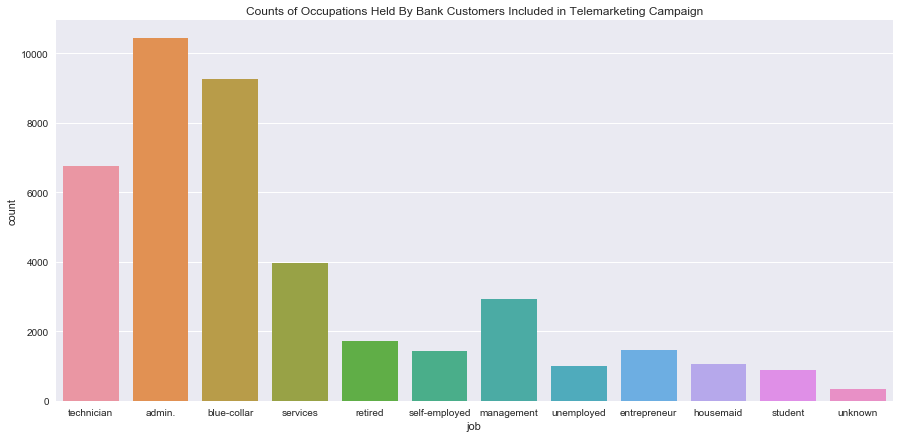

In [4]:
plt.figure(figsize=(15, 7))
sortedjobs = pd.DataFrame()
sortedjobs = np.sort(data['job'])
plt.title("Counts of Occupations Held By Bank Customers Included in Telemarketing Campaign")
sns.countplot(data['job'])
#plt.savefig("/Users/jacquelynzuker/Desktop/bank_occupations.png")

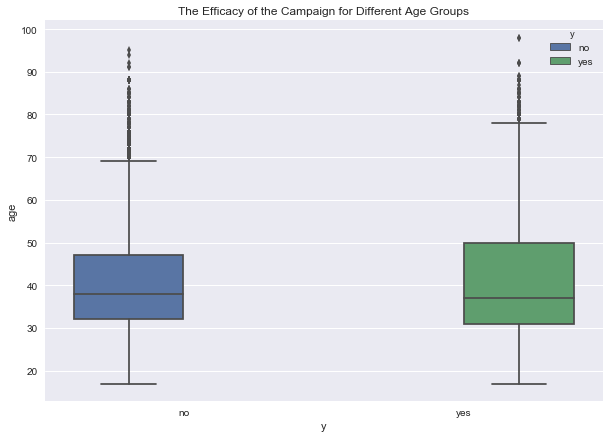

In [5]:
plt.figure(figsize = (10,7))
sns.boxplot(data.y, data.age, hue = data.y)
plt.title("The Efficacy of the Campaign for Different Age Groups")
plt.savefig("/Users/jacquelynzuker/Desktop/ageboxplot.png")
plt.show()

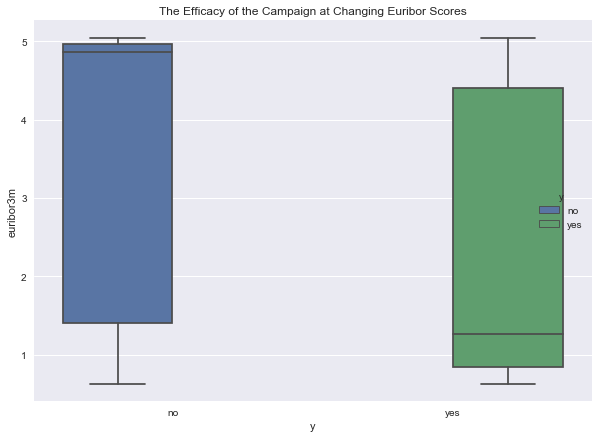

In [6]:
plt.figure(figsize = (10,7))
sns.boxplot(data.y, data.euribor3m, hue = data.y)
plt.title("The Efficacy of the Campaign at Changing Euribor Scores")
plt.savefig("/Users/jacquelynzuker/Desktop/euriborboxplot.png")
plt.show()

In [7]:
# Encode the 'y' outcome to numerical categories
data.y = data.y.apply(lambda x: 1 if x == 'yes' else 0)

In [8]:
#linear_model.LinearRegression()

## Data Cleaning

In [9]:
nans = pd.isnull(data).sum()
missing = nans[nans>0]
missing = list(missing.index)
print(missing)

# Drop the duration variable, because this variable is useless for prediction purposes (value is not known until 
# call completed)
data = data.drop(['duration'], axis = 1)

[]


No nulls or missing values exist in this dataset.

## Feature Engineering

### Class Imbalance 
In this dataset we have a class imbalance problem. The positive outcomes only comprise ~13% of the dataset. This leads to models overly predicting a 'no' outcome because it is statistically safer. One approach is to remove a subset of the 'no' samples so that the two classes are balanced (i.e. ***under-sampling***) Another approach is to multiply the 'yes' samples so that both classes are of equal size. (i.e. ***over-sampling***) This will result in a better outcome than deleting 'no' samples, even if the 'yes' results become more weighted. 

In [10]:
def balanceClasses(data, method):
    if method == "over":
        # Over-Sampling script
        diff = len(data[data.y ==0]) - len(data[data.y == 1])
        data_extrayes = data[data.y ==1].sample(diff, replace=True)
        data = data.append(data_extrayes)
        data = data.sample(frac=1).reset_index(drop=True)
        print(data.y.value_counts())
        return data
    elif method == "mixed":
        data_extrayes = data[data.y ==1].sample(2 * len(data[data.y == 1]), replace=True)
        data_lessno = data[data.y == 0].sample(len(data_extrayes), replace= False)
        dataBalanced = data_extrayes.append(data_lessno)
        data = data.sample(frac=1).reset_index(drop=True)
        print(dataBalanced.y.value_counts())
        return dataBalanced
    
data = balanceClasses(data, 'mixed')    

1    9280
0    9280
Name: y, dtype: int64


In [11]:
data.y.value_counts()

1    9280
0    9280
Name: y, dtype: int64

In [12]:
label = data['y']
data = data.drop(['day_of_week'] , 1)
dataDummies = pd.get_dummies(data = data)
dataDummies.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_nonexistent,poutcome_success
9278,52,2,999,0,1.4,93.918,-42.7,4.962,5228.1,1,...,1,0,0,0,0,0,0,0,1,0
4570,19,1,999,0,-1.8,93.075,-47.1,1.405,5099.1,1,...,0,0,0,0,0,0,0,0,1,0
6470,78,4,999,0,-1.7,94.055,-39.8,0.729,4991.6,1,...,0,1,0,0,0,0,0,0,1,0
7178,55,9,999,0,1.4,94.465,-41.8,4.967,5228.1,1,...,0,1,0,0,0,0,0,0,1,0
21343,63,1,6,2,-2.9,92.201,-31.4,0.884,5076.2,1,...,0,0,0,0,0,0,0,1,0,0


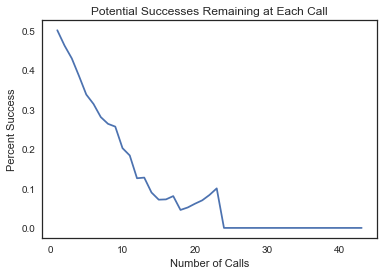

In [13]:
def cost_function(call_number, data):
    success_rate = len(data[((data['campaign']>=call_number) & 
                             (data['y']==1))]) / len(data[data['campaign'] >= call_number])
    return success_rate
sorted_campaign = np.sort(data['campaign'].unique())
successes_callnum = list()
successes = list()
#for campaign_call in range(len(data['campaign'].unique())):
for campaign_call in sorted_campaign:
    successes_callnum.append(campaign_call)
    successes.append(cost_function(campaign_call, data))    

    
sns.set_style('white')    
plt.plot(successes_callnum, successes)    
plt.title('Potential Successes Remaining at Each Call')
plt.xlabel("Number of Calls")
plt.ylabel("Percent Success")
plt.show()

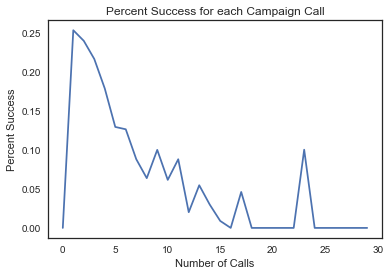

In [14]:
def cost_function(call_number, data):
    success_rate = len(data[((data['campaign']==call_number) & 
                             (data['y']==1))]) / len(data[data['campaign'] >= call_number])
    return success_rate

successes = list()
for campaign_call in range(len(data['campaign'].unique())):
    successes.append(cost_function(campaign_call, data))    

    
sns.set_style('white')    
plt.plot(successes[:30])    
plt.title('Percent Success for each Campaign Call')
plt.xlabel("Number of Calls")
plt.ylabel("Percent Success")

In [15]:
datasuccess = data.groupby(data['y']).mean()
datasuccess

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,
0,39.899030,2.608082,982.742349,0.134159,0.262004,93.602196,-40.555356,3.829102,5176.860948
1,40.870797,2.028233,789.361315,0.490517,-1.247112,93.347590,-39.762037,2.114582,5094.688664


## Feature Filtering

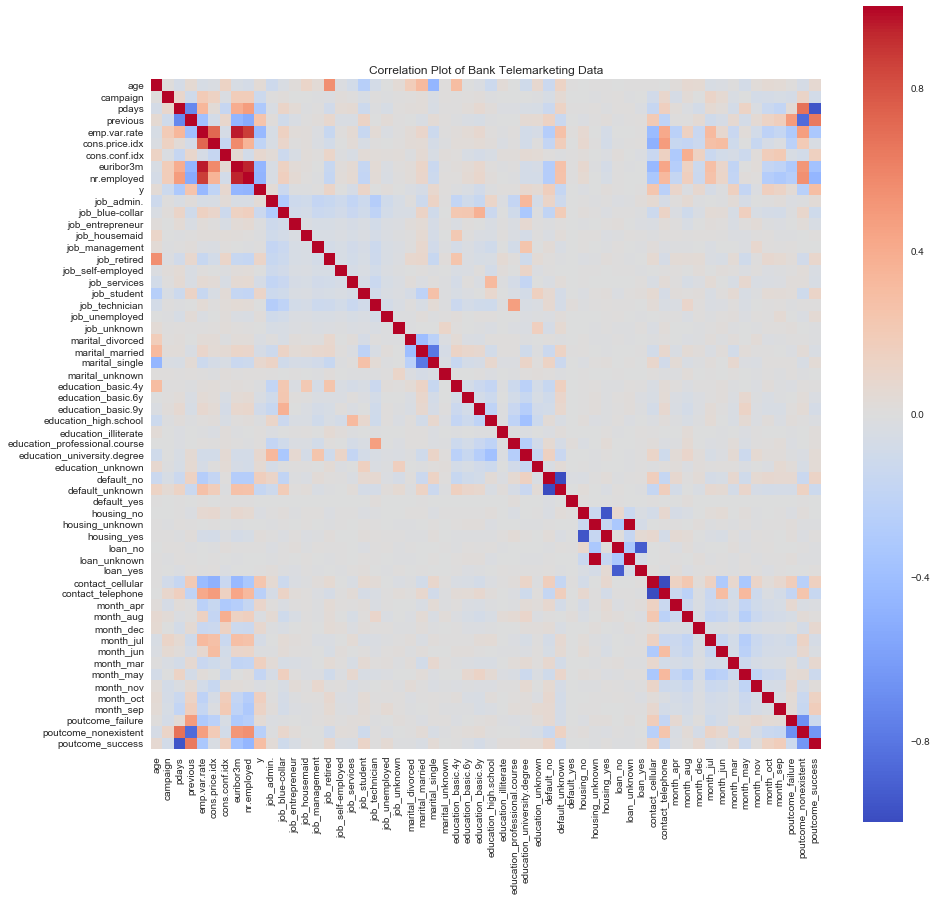

In [16]:
# Set up the matplotlib figure
plt.figure(figsize = (15,15))

# Begin with every feature in the feature set
all_features = dataDummies.columns

# Correlation matrix of numerical features
corrmat = dataDummies[all_features].corr()

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax = .8, square = True, cmap = 'coolwarm')
plt.title("Correlation Plot of Bank Telemarketing Data")
#plt.savefig("/Users/jacquelynzuker/Desktop/bank_corrs.png")
plt.show()

In [17]:
# Filter features 
best_features = corrmat[corrmat["y"] >= 0.02]
best_features = list(best_features.index)

best_neg_features = corrmat[corrmat["y"] <= -0.02]
best_neg_features = list(best_neg_features.index)

all_best_features = best_features + best_neg_features

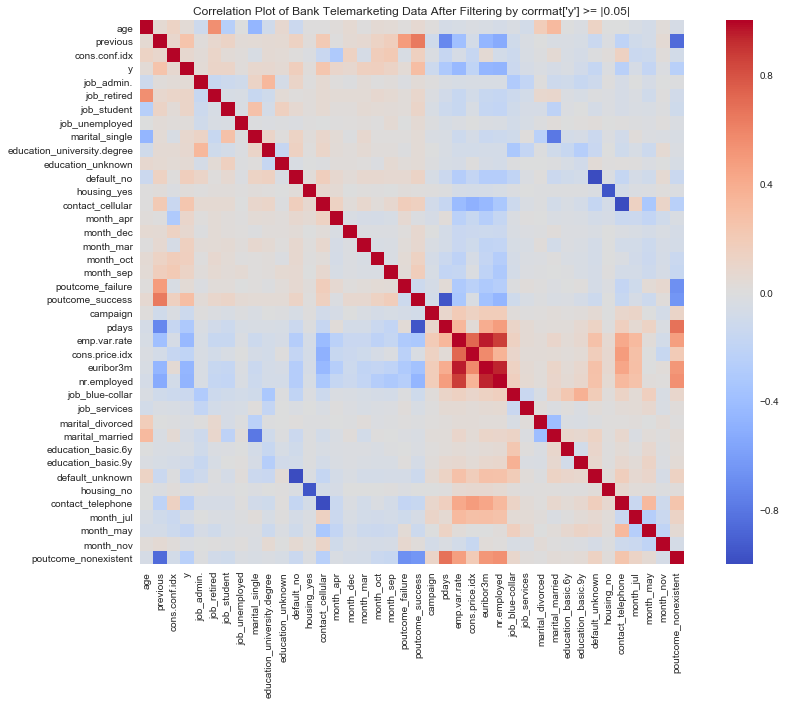

In [18]:
# Correlation matrix of numerical features
corrmat = dataDummies[all_best_features].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax = .8, square = True, cmap = 'coolwarm')
plt.title("Correlation Plot of Bank Telemarketing Data After Filtering by corrmat['y'] >= |0.05|")
#plt.savefig("/Users/jacquelynzuker/Desktop/bank_corrsAfterFiltering.png")
plt.show()

In [19]:
# Remove y outcome from predictive model and reassign. 
label = data.y
dataDummies.columns
dataDummies.drop('y', axis = 1, inplace = True)
all_best_features.remove('y')

# Predictive Models

## Naive Bayes


In [20]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
X = dataDummies[all_best_features]
Y = label
nb_score = cross_val_score(gnb, X, Y, cv=10)
print("Cross-Validated R-Squared of Naive Bayes Classification Model: %0.2f (+/- %0.2f)" 
      % (nb_score.mean(), nb_score.std() * 2))

Cross-Validated R-Squared of Naive Bayes Classification Model: 0.70 (+/- 0.01)


## Logistic Regression

In [21]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

regr = linear_model.LogisticRegression()
Y = label
X = dataDummies[all_best_features]
regr.fit(X, Y)

# Inspect the results.
regr_score = cross_val_score(regr, X, Y, cv=10)
print("Cross-Validated R-Squared of Logistic Regression Model: %0.2f (+/- %0.2f)" 
      % (regr_score.mean(), regr_score.std() * 2))

Cross-Validated R-Squared of Logistic Regression Model: 0.75 (+/- 0.02)


## SVC

In [22]:
# Y = label
# X = dataDummies[all_features.drop('y')]

# from sklearn.decomposition import PCA
# pca = PCA(n_components=30, whiten=True)
# a = pca.fit(X, Y)
# variance = pd.DataFrame(pca.explained_variance_ratio_)

# plt.figure(1, figsize=(9, 6))
# plt.clf()
# plt.axes([.2, .2, .7, .7])
# plt.axis([0, 31, 0, 1])

# dat = range(1, 31)
# plt.plot(dat, variance, marker='o')

# plt.axis('tight')
# plt.xlabel('Number of components')
# plt.ylabel('Explained Variance')
# plt.title("Scree Plot Showing Percent Variability Explained by Each Eigenvalue")

# plt.show()

In [23]:
# from sklearn.svm import SVC 

# svc = SVC()
# pca = PCA(n_components=2, whiten=True)
# X_pca = pca.fit_transform(X)
# #variance = pd.DataFrame(pca.explained_variance_ratio_)
# transf = X_pca
# svc.fit(X_pca, Y)
# prediction = svc.predict(X_pca)

# class1 = label[label == 1]
# class2 = label[label == 0]

# print(len(class1))
# print(len(class2))

# # Transpose the class labels
# class1T = class1.T
# class2T = class2.T

# #pca = PCA(n_components=2, whiten=True)
# #transf = pca.fit_transform(logged_homePrices_with_dummies)
# transf_label = label.T


In [24]:
# plt.figure(figsize=(10, 7))
# plt.plot(transf[class1T.index,0],transf[class1T.index,1], 'o', 
#          markersize=7, color='blue', alpha=0.5, 
#          label='Successful Sales')
# plt.plot(transf[class2T.index,0],transf[class2T.index,1], 'o', 
#          markersize=7, color='green', alpha=0.5, 
#          label='Unsuccessful Sales')

# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')
# plt.xlim([-3,3])
# plt.ylim([-3,3])
# plt.legend()
# plt.title("PCA Plot")
# plt.show()

In [25]:
# svc_pca_score = cross_val_score(svc, X_pca, Y, cv=10)
# print("Cross-Validated R-Squared of SVC Model: %0.2f (+/- %0.2f)" 
#       % (svc_pca_score.mean(), svc_pca_score.std() * 2))


In [26]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(Y, prediction)


## SVC without PCA
    

In [27]:
# from sklearn.svm import SVC 

# Y = label
# X = dataDummies[all_features.drop('y')]

# svc = SVC()
# svc_score = cross_val_score(svc, X, Y, cv=10)
# print("Cross-Validated R-Squared of SVC Model: %0.2f (+/- %0.2f)" 
#       % (svc_score.mean(), svc_score.std() * 2))

### Random Forest

In [28]:
Y = label
X = dataDummies[all_features.drop('y')]

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 500, max_depth = 10)

rfc_score = cross_val_score(rfc, X, Y, cv = 10)
print("Random Forest: %0.2f (+/- %0.2f)" % (rfc_score.mean(), rfc_score.std() * 2))

Random Forest: 0.76 (+/- 0.01)


In [29]:
rfc.fit(X,Y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


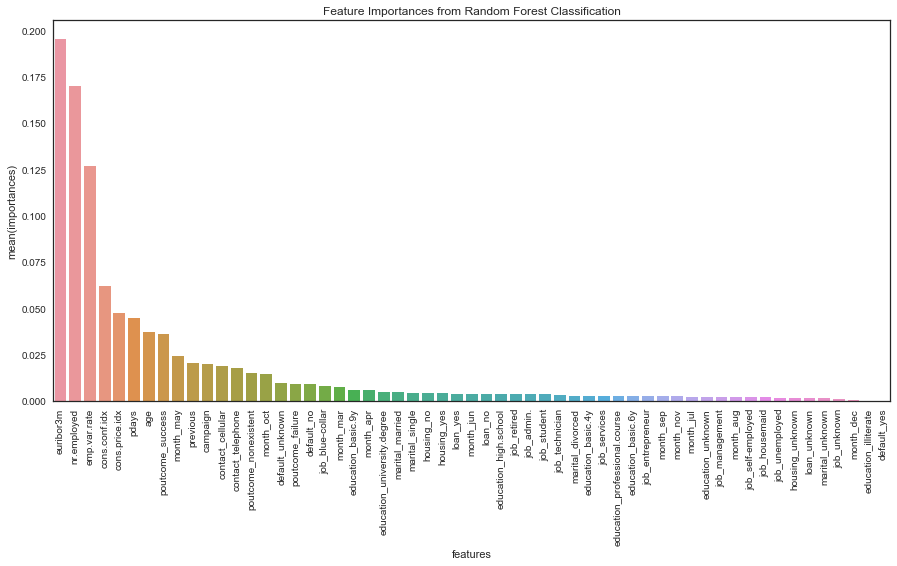

In [30]:

features = list(X.columns)
importances = list(rfc.feature_importances_)
index = range(len(X.columns))

d = {'features': features, 'importances': importances}
best_features = pd.DataFrame(data=d, index=index)
best_features.sort(columns="importances", ascending = False, inplace=True)

#best10 = best_features[:10]

plt.figure(figsize = (15, 7))
sns.barplot(best_features["features"], best_features["importances"])
#
#sns.barplot(best_features["features"], best_features["importances"])
plt.title("Feature Importances from Random Forest Classification")
plt.xticks(rotation = 90)
plt.savefig("/Users/jacquelynzuker/Desktop/featureImportancesRFC", bbox_inches = 'tight', pad_inches=0.5)

In [31]:
#sns.distplot(data[data['age'] & data['y'] == 1])
#sns.distplot(data[data['age'] & data['y'] == 0])

In [32]:
# Choose best features, export csv and make charts
#export_features = pd.DataFrame(data[["euribor3m", "age", 'campaign', "emp.var.rate", "nr.employed"]])
#export_features.to_csv('/Users/jacquelynzuker/Desktop/marketingData.csv')
#data.nr.employed

### Boosted Models: Gradient Descent

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

Y = label
X = dataDummies[all_features.drop('y')]

gb_class = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1,
    max_depth=5)

gb_class_score = cross_val_score(gb_class, X, Y, cv=10)
print("Gradient Boost Classification: %0.2f (+/- %0.2f)" % (gb_class_score.mean(), gb_class_score.std() * 2))

Gradient Boost Classification: 0.80 (+/- 0.01)


In [34]:
gbc = gb_class.fit(X, Y)
gbc.feature_importances_

gbc_features = list(X.columns)
gbc_importances = list(gbc.feature_importances_)
index = range(len(X.columns))

d = {'features': gbc_features, 'importances': gbc_importances}
gbc_best_features = pd.DataFrame(data=d, index=index)
gbc_best_features.sort(columns="importances", ascending = False, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56]), <a list of 57 Text xticklabel objects>)

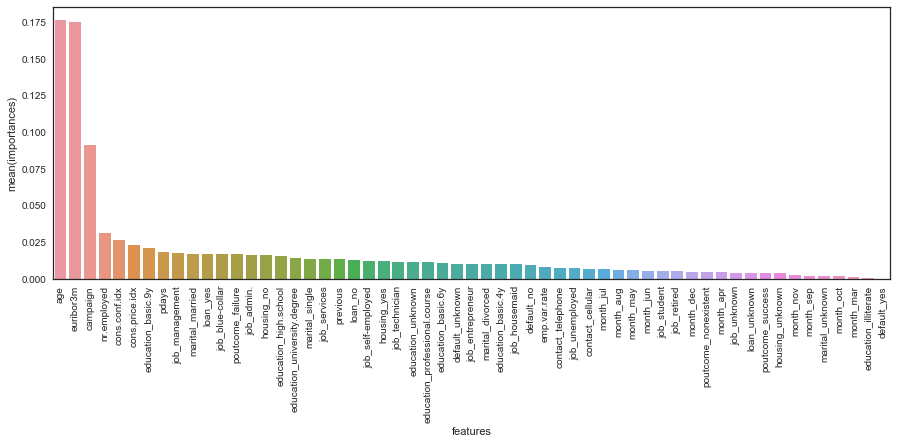

In [35]:
plt.figure(figsize = (15,5))
sns.barplot(gbc_best_features["features"], gbc_best_features["importances"])
plt.xticks(rotation = 90)

In [36]:
#percentSuccess = data.groupby(data.euribor3m).mean()
#percentSuccess
#sns.regplot(percentSuccess.index, percentSuccess.y)
rfc_score.shape

(10,)

In [39]:
scores = pd.DataFrame()

scores["Random Forest"] = rfc_score
scores["Gradient Boost"] = gb_class_score
#scores["SVC without PCA"] = svc_score
scores["Logistic Regression"] = regr_score
#scores["SVC with PCA"] = svc_pca_score
scores["Naive Bayes Classifier"] = nb_score


results = pd.DataFrame()
results["Model"] = ("Naive Bayes", "Logistic Regression", "Random Forest", 
                    "Gradient Boost")
results["Score"] = (nb_score.mean(), regr_score.mean(), rfc_score.mean(), 
                    gb_class_score.mean())
results["Standard Deviation"] = (nb_score.std(), regr_score.std(), 
                                 rfc_score.std(), gb_class_score.std())
results

,Model,Score,Standard Deviation
0,Naive Bayes,0.699084,0.006976
1,Logistic Regression,0.745474,0.008645
2,Random Forest,0.761853,0.007152
3,Gradient Boost,0.799084,0.006040


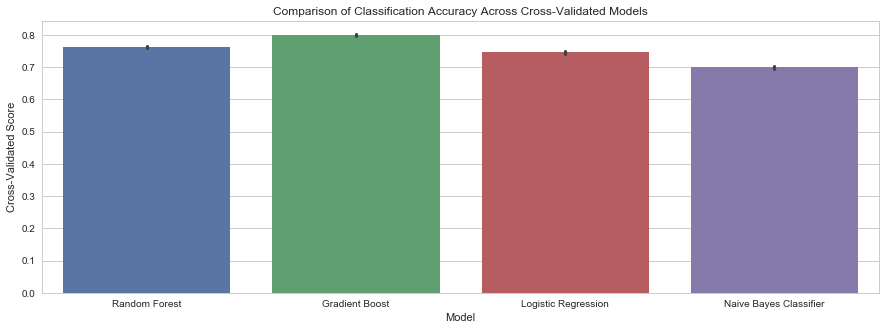

In [40]:
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.barplot(data=scores)
plt.xlabel("Model")
plt.ylabel("Cross-Validated Score")
plt.title("Comparison of Classification Accuracy Across Cross-Validated Models")
#plt.savefig("/Users/jacquelynzuker/Desktop/ModelComparison")
plt.show()

## First Contact: 
### Where to focus marketing effort? 

In [41]:
probs = rfc.predict_proba(X)



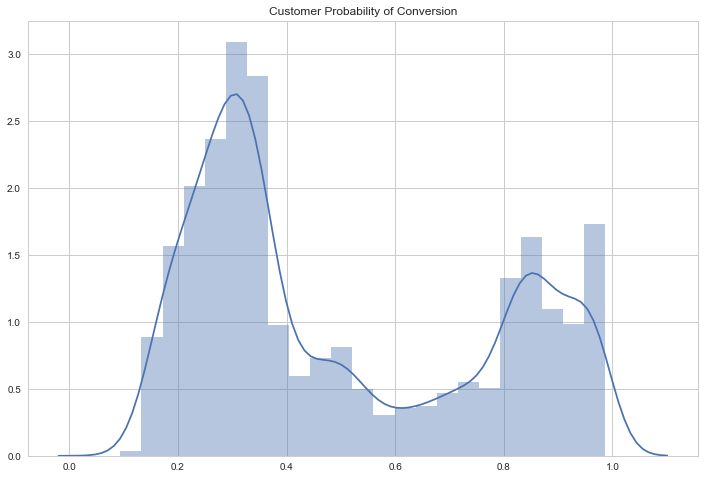

In [42]:

#plt.hist(probs[1])
chances = []
for prob in (probs):
    chances.append((prob[1]))
chances    

plt.figure(figsize=(12,8))
sns.distplot(chances)
plt.title("Customer Probability of Conversion")
plt.savefig("/Users/jacquelynzuker/Desktop/ProbOfConversion")


In [43]:
best_features[:5]

,features,importances
7,euribor3m,0.195637
8,nr.employed,0.170256
4,emp.var.rate,0.126687
6,cons.conf.idx,0.061987
5,cons.price.idx,0.047597


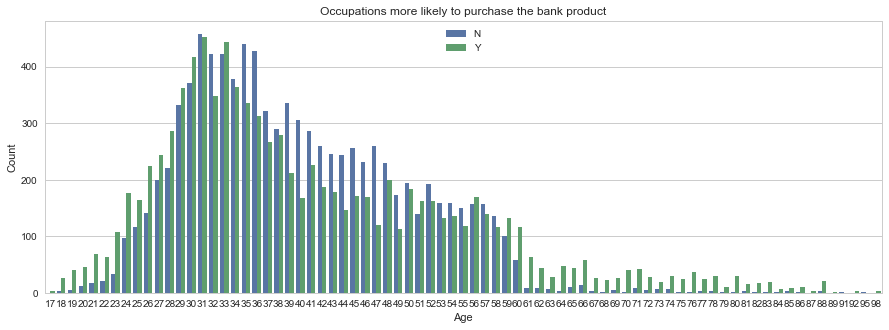

In [44]:
plt.figure(figsize=(15,5))
sns.countplot(data['age'], hue = data['y'])
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend("NY")
plt.title("Occupations more likely to purchase the bank product")
plt.show()

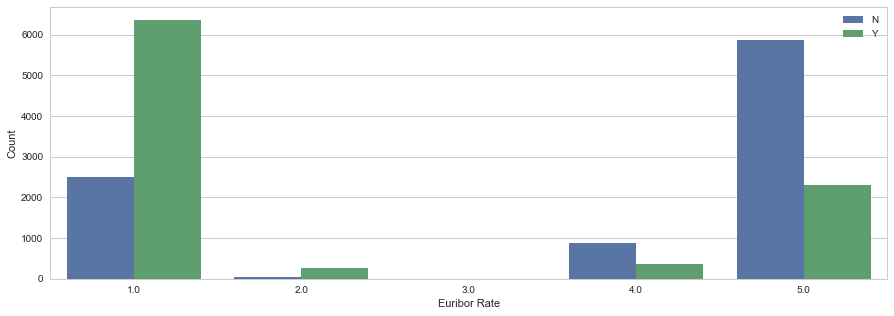

In [45]:
binned_Euribor = np.round(data['euribor3m'])

plt.figure(figsize=(15,5))
#sns.countplot(data['euribor3m'], hue = data['y'])
sns.countplot(binned_Euribor, hue = data['y'])

plt.xlabel("Euribor Rate")
plt.ylabel("Count")
plt.legend("NY")
plt.title("")
plt.show()

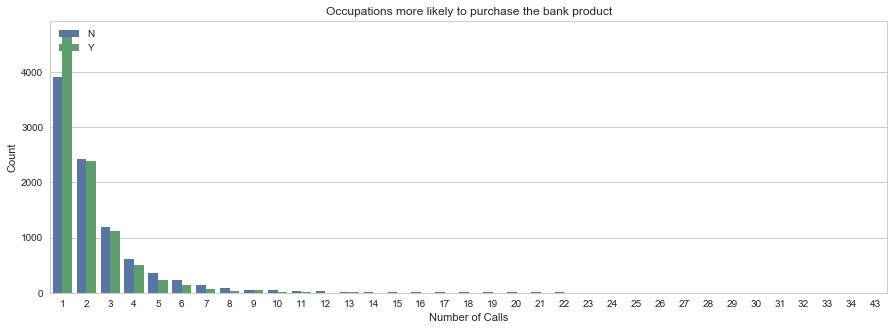

In [46]:
plt.figure(figsize=(15,5))
sns.countplot(data['campaign'], hue = data['y'])
plt.xlabel("Number of Calls")
plt.ylabel("Count")
plt.legend("NY")
plt.title("Occupations more likely to purchase the bank product")
plt.show()

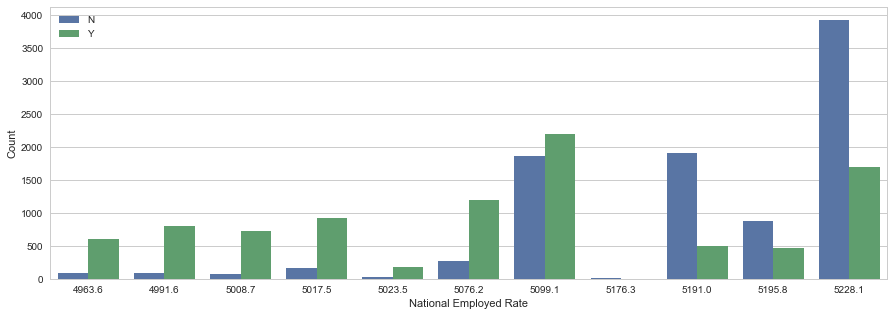

In [47]:
plt.figure(figsize=(15,5))
sns.countplot(data['nr.employed'], hue = data['y'])
plt.xlabel("National Employed Rate")
plt.ylabel("Count")
plt.legend("NY")
plt.show()

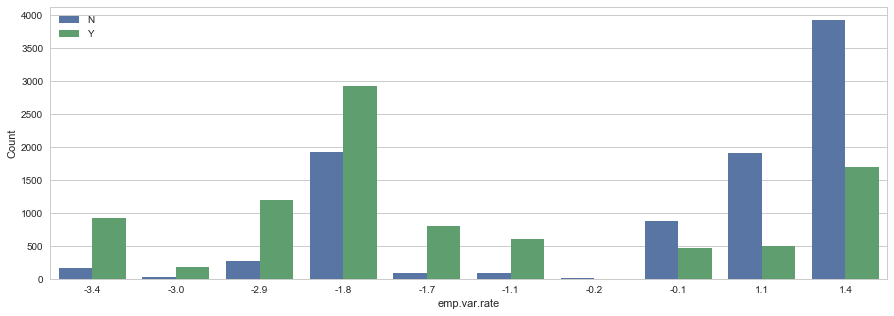

In [48]:
plt.figure(figsize=(15,5))
sns.countplot(data['emp.var.rate'], hue = data['y'])
plt.xlabel("emp.var.rate")
plt.ylabel("Count")
plt.legend("NY")
plt.show()

Source:

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


Attribute Information:

Input variables:
#### bank client data:
1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone') 

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output 
target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric) 

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')


Relevant Papers:

S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimaraes, Portugal, October, 2011. EUROSIS. [bank.zip]




In [49]:
# First Contact: 

